In [1]:
#Journal 5 - Exercises from 'Think Bayes' 2-1, 3-1, 4-1, 4-2

In [2]:
from __future__ import print_function, division

import numpy as np

import thinkbayes2
from thinkbayes2 import Pmf, Cdf, Suite, Hist, Beta
import thinkplot

% matplotlib inline

#using the authors' (Allen Downey's) solutions as a guide

In [3]:
#Exercise 2.1. 

#In Section 2.3 I said that the solution to the cookie problem generalizes
#to the case where we draw multiple cookies with replacement.

#But in the more likely scenario where we eat the cookies we draw, the likelihood of
#each draw depends on the previous draws.

#Modify the solution in this chapter to handle selection without replacement.

#Hint: add instance variables to Cookie to represent the hypothetical state of the bowls,
#and modify Likelihood accordingly. You might want to define a Bowl object.

In [4]:
#using a 'Hist' object (thinkbayes2), we keep track of cookies in each bowl

#from documentation:
#Hist: represents a histogram (map from values to integer frequencies).

bowl1 = Hist(dict(vanilla=30, chocolate=10))
bowl2 = Hist(dict(vanilla=20, chocolate=20))

bowl1.Print()

chocolate 10
vanilla 30


In [5]:
#Create 'pmf' containing 2 bowls, with equal probability

#from documentation:
#Pmf: represents a probability mass function (map from values to probs).

pmf = Pmf([bowl1, bowl2])
pmf.Print()

Hist({'vanilla': 30, 'chocolate': 10}) 0.5
Hist({'vanilla': 20, 'chocolate': 20}) 0.5


In [6]:
#define likelihood, remove one cookie
#'hypo' is bowl type
#'data' is flavor

def likelihood(hypo, data):
    like = hypo[data] / hypo.Total()
    if like:
        hypo[data] -= 1
    return like

In [7]:
#define update
#loop through the hypo
#likelihood of data with each revisited hypo

def update(pmf, data):
    for hypo in pmf:
        pmf[hypo] *= likelihood(hypo, data)
    return pmf.Normalize()

In [8]:
#subtracts vanilla cookie
#updates prob

update(pmf, 'vanilla')
pmf.Print()

Hist({'vanilla': 29, 'chocolate': 10}) 0.6000000000000001
Hist({'vanilla': 19, 'chocolate': 20}) 0.4


In [9]:
#subtracts chocolate cookie
#updates prob

#with enough iterations, bowl 1 prob 0.0
#as we run out of chocolate in bowl 1

update(pmf, 'chocolate')
pmf.Print()

Hist({'vanilla': 29, 'chocolate': 9}) 0.4285714285714286
Hist({'vanilla': 19, 'chocolate': 19}) 0.5714285714285714


In [10]:
#Exercise 3.1: 

#To write a likelihood function for the locomotive problem, we had to answer this question:
#"If the railroad has N locomotives, what is the probability that we see number 60?"

#The answer depends on what sampling process we use when we observe the locomotive.
#In this chapter, I resolved the ambiguity by specifying that there is only one train-operating company
#(or only one that we care about).

#But suppose instead that there are many companies with different numbers of trains.
#And suppose that you are equally likely to see any train operated by any company.
#In that case, the likelihood function is different because you are more likely to see a train operated by a large company.

#As an exercise, implement the likelihood function for this variation of the locomotive problem, and compare the results.

In [11]:
#likelihood function

class Train(Suite):
    def Likelihood(self, data, hypo):
        if hypo < data:
            return 0
        else:
            return 1/hypo

In [12]:
#set range up to 1000 locos
#set update

hypos = range(1, 1001)
suite = Train(hypos)
suite.Update(60)

0.0028222671142652746

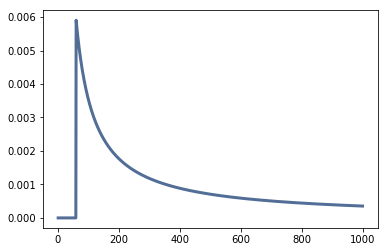

In [13]:
thinkplot.Pdf(suite)

In [14]:
#discounts values below 60
#mean is better options

def Mean(suite):
    total = 0
    for hypo, prob in suite.Items():
        total += hypo * prob
    return total

Mean(suite)

333.41989326371095

In [15]:
def MakePosterior(high, dataset, constructor=Train):
    """Solves the train problem.
    
    high: int max number of trains
    dataset: sequence of observed train numbers
    constructor: function used to construct the Train object
    
    returns: Train object representing the posterior suite
    """
    hypos = range(1, high+1)
    suite = constructor(hypos)

    for data in dataset:
        suite.Update(data)

    return suite

In [16]:
#get more data
#get more posteriors

dataset = [30, 60, 90]

for high in [500, 1000, 2000]:
    suite = MakePosterior(high, dataset)
    print(high, suite.Mean())

500 151.84958795903822
1000 164.30558642273363
2000 171.33818109150937


In [17]:
#power law prior

class Train2(Train):

    def __init__(self, hypos, alpha=1.0):
        Pmf.__init__(self)
        for hypo in hypos:
            self[hypo] = hypo**(-alpha)
        self.Normalize()

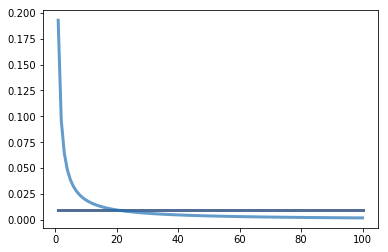

In [18]:
#power vs uniform prior

high = 100
hypos = range(1, high+1)
suite1 = Train(hypos)
suite2 = Train2(hypos)
thinkplot.Pdf(suite1)
thinkplot.Pdf(suite2)

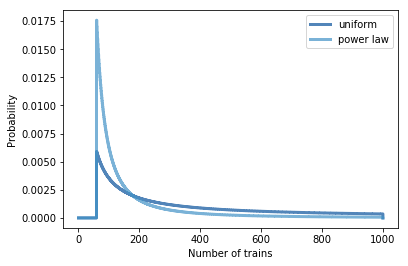

In [19]:
#posteriors after observing 1 train

dataset = [60]
high = 1000

thinkplot.PrePlot(num=2)

constructors = [Train, Train2]
labels = ['uniform', 'power law']

for constructor, label in zip(constructors, labels):
    suite = MakePosterior(high, dataset, constructor)
    suite.label = label
    thinkplot.Pmf(suite)

thinkplot.Config(xlabel='Number of trains',
                 ylabel='Probability')

#power law has less prob for high values -> lower posterior + less sensitivity to upper bound

In [20]:
dataset = [30, 60, 90]

for high in [500, 1000, 2000]:
    suite = MakePosterior(high, dataset, Train2)
    print(high, suite.Mean())

500 130.70846986256004
1000 133.2752313750312
2000 133.99746308073065


In [21]:
#credible intervals, percentile method on posterior

hypos = range(1, 1001)
suite = Train(hypos)
suite.Update(60)

suite.Percentile(5), suite.Percentile(95)

(69, 869)

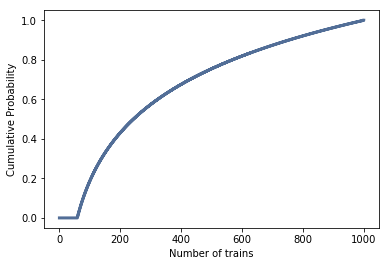

In [22]:
#more observations, compute CDF

cdf = Cdf(suite)
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel='Number of trains',
                 ylabel='Cumulative Probability',
                 legend=False)

In [23]:
cdf.Percentile(5), cdf.Percentile(95)

(69, 869)

In [24]:
#Excersize 4.1

#Exercise Suppose that instead of observing coin tosses directly,
#you measure the outcome using an instrument that is not always correct.

#Specifically, suppose there is a probability y that an actual heads is reported as tails,
#or actual tails reported as heads.

#Write a class that estimates the bias of a coin given a series of outcomes and the value of y.

#How does the spread of the posterior distribution depend on y?

In [25]:
#create class for an unreliable coin

class UnreliableCoin(Suite):
    
    def __init__(self, prior, y):
        """
        prior: seq or map
        y: prob of accurate measurement
        """
        Suite.__init__(self, prior)
        self.y = y
    
    def Likelihood(self, data, hypo):
        """
        data: outcome of unreliable measurement ('H' or 'T' )
        hypo: prob of heads (0-100)
        """
        x = hypo / 100
        y = self.y
        if data == 'H':
            return x*y + (1-x)*(1-y)
        else:
            return x*(1-y) + (1-x)*y

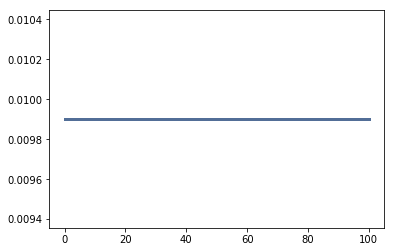

In [26]:
#initiliaze with 'y=0.9'
#which represents prob of accurate measurement

prior = range(0, 101)
suite = UnreliableCoin(prior, y=0.9)
thinkplot.Pdf(suite)

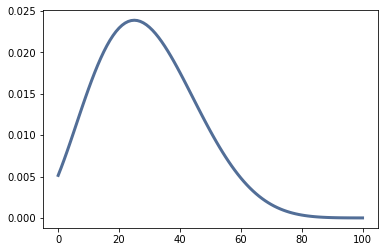

In [27]:
#create outcome
#3 Heads, 7 Tails

for outcome in 'HHHTTTTTTT':
    suite.Update(outcome)
    
thinkplot.Pdf(suite)

In [28]:
#try different values of 'y' on same plot

def compute_prior(y):
    prior = range(0, 101)
    suite = UnreliableCoin(prior, y=y)
    for outcome in 'HHHTTTTTTT':
        suite.Update(outcome)
    
    thinkplot.Pdf(suite, label='y=%g' % y)

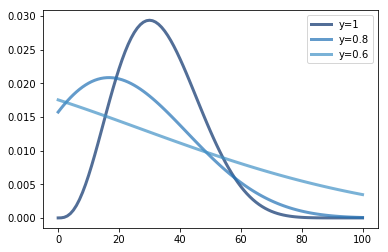

In [29]:
compute_prior(1)
compute_prior(0.8)
compute_prior(0.6)
thinkplot.config(legend=True)

#distrubution is wider with less reliability (smaller y)

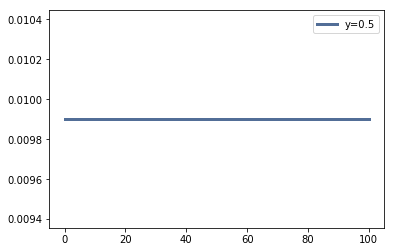

In [30]:
#prior=posterior

compute_prior(0.5)
thinkplot.config(legend=True)

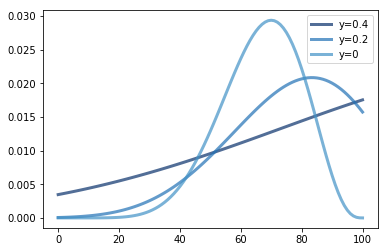

In [31]:
#distribution begins to get narrower after passing the y=0.5 mark as reliability decreases

compute_prior(0.4)
compute_prior(0.2)
compute_prior(0.0)
thinkplot.config(legend=True)

In [32]:
#Exercise 4.2

#This exercise is inspired by a question posted by a “redditor”
#named dominosci on Reddit’s statistics “subreddit” (r/statistics).

#Reddit is an online forum with many interest groups called subreddits. Users,
#called redditors, post links to online content and other web pages. 
#Other redditors vote on the links, giving an “upvote” to high-quality links and a “downvote” to
#links that are bad or irrelevant.

#A problem, identified by dominosci, is that some redditors are more reliable than
#others, and Reddit does not take this into account.

#The challenge is to devise a system so that when a redditor casts a vote, the estimated
#quality of the link is updated in accordance with the reliability of the redditor, and
#the estimated reliability of the redditor is updated in accordance with the quality of
#the link.

#One approach is to model the quality of the link as the probability of garnering an
#upvote, and to model the reliability of the redditor as the probability of correctly
#giving an upvote to a high-quality item.

#Write class definitions for redditors and links and an update function that updates
#both objects whenever a redditor casts a vote.

In [33]:
#quality (q): prob of article getting upvote from reliable redditor.

#reliability (r): prob of user giving upvote w/ q=1.

#we update our belief about the redditor and the item w/ voting

class Redditor(Suite):
    """hypo of redditor's trustworthiness"""

    def Likelihood(self, data, hypo):
        """likelihood of the data w/ the hypo

        hypo: integer value of r, the prob of a correct vote (0-100)
        data: (vote, q) pair, vote is 'up' or 'down' and
              q is the mean quality of the link
        """
        r = hypo / 100.0
        vote, q = data

        if vote == 'up':
            return r * q + (1-r) * (1-q)
        elif vote == 'down':
            return r * (1-q) + (1-r) * q
        else:
            return 0

In [34]:
class Item(Suite):
    """hypo about quality of item"""

    def Likelihood(self, data, hypo):
        """likelihood of the data under the hypothesis

        hypo: integer value of x, the prob of getting upvote
        data: (vote, t) pair, vote is 'up' or 'down' and
              t is the mean trustworthiness of redditor
        """
        x = hypo / 100.0
        vote, r = data

        if vote == 'up':
            return x * r + (1-x) * (1-r)
        elif vote == 'down':
            return x * (1-r) + (1-x) * r
        else:
            return 0    

0.67

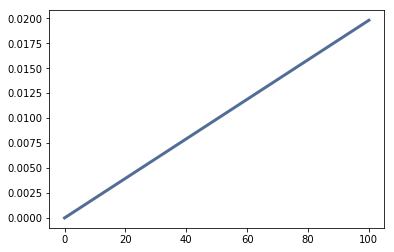

In [35]:
#start with a redditor who has demo'd some reliability

redditor = Redditor(label='redditor')
beta = Beta(2, 1)
for val, prob in beta.MakePmf().Items():
    redditor.Set(val*100, prob)
    
thinkplot.Pdf(redditor)
mean_r = redditor.Mean() / 100.0
mean_r

0.5000000000000001

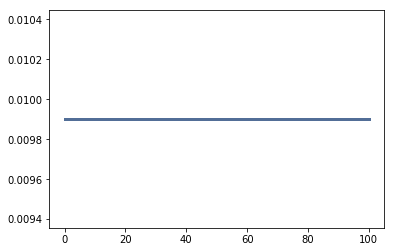

In [36]:
#unknown item

item = Item(range(0, 101), label='item')

thinkplot.Pdf(item)
mean_q = item.Mean() / 100.0
mean_q

In [37]:
#update the priors, using the mean value of the other.

redditor.Update(('up', mean_q))
item.Update(('up', mean_r))

0.5000000000000001

66.99999999999999 (22.0, 98.0)


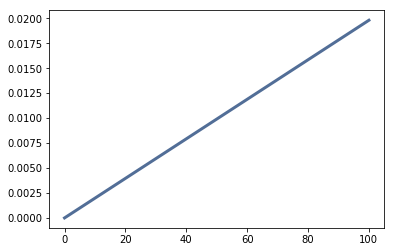

In [38]:
#results
#we knew nothing about the item - vote gives no info about redditor

thinkplot.Pdf(redditor)
print(redditor.Mean(), redditor.CredibleInterval(90))

55.780000000000015 (7, 97)


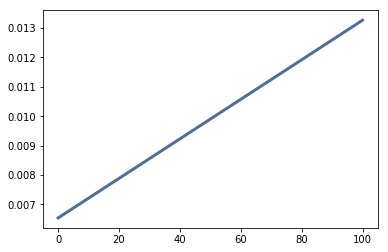

In [39]:
#now we factor in that the redditor is reliable
#vote provides info about the item

thinkplot.Pdf(item)
print(item.Mean(), item.CredibleInterval(90))

#after upvote, mean quality of item increases to ~56%